# TV-regularized reconstruction of the dynamix STEMPO dataset in CIL

Based mostly on the work carried out during the CIL Hackathon in Cambridge, UK 20-23 March 2023.

Created by [Tommi Heikkilä](https://github.com/tommheik), University of Helsinki, Finland.

Special thanks to the CIL team and Christoph Kolbitsch (PTB) for all the help.

Computations performed using `CIL 23.0.1`.

## General outline

1. Setup: CIL, load the data, the geometry etc.
2. Start with static data and single time step reconstruction
3. Move to dynamic data and single time step reconstruction
4. Split dynamic data into multiple time steps (batches)
5. Reconstruct each at the same time using FISTA and (spatial) TV regularization
6. ??? (Inefficient temporal + spatial TV implementation)

## Future goal

Temporal (anisotropic) TV regularization (i.e regularize across time steps) for controlled temporal evolution. Preferably in a more efficient manner, similar to *Papoutsellis E et al.* (2021) [Core Imaging Library - Part II: multichannel reconstruction for dynamic and spectral tomography](https://doi.org/10.1098/rsta.2020.0193). Phil. Trans. R. Soc. A 20200193.

**Note**: it is very likely that the approach taken here (`Partitioner`) is not suitable for this.

## License

This code is licensed under the Apache License, Version 2.0 which is availalbe at: http://www.apache.org/licenses/LICENSE-2.0

The STEMPO Dataset is licensed under Creative Commons Attributiom 4.0 International: https://creativecommons.org/licenses/by/4.0/legalcode

In [1]:
# cil imports
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData, BlockDataContainer

from cil.processors import Slicer, AbsorptionTransmissionConverter, TransmissionAbsorptionConverter

from cil.optimisation.functions import IndicatorBox, LeastSquares, ZeroFunction
from cil.optimisation.algorithms import CGLS, SIRT, FISTA
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.recon import FDK
from cil.plugins import TomoPhantom

from cil.utilities import dataexample
from cil.utilities.display import show2D, show1D, show_geometry

# External imports
import numpy as np
import matplotlib.pyplot as plt
import logging
import scipy.io
import os
import mat73 # This makes loading MATLAB v7.3 files much easier

In [2]:
# Set logging level for CIL processors:
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

## 1. Load STEMPO data
Data is available in Zenodo: 
https://zenodo.org/record/7147139 / https://doi.org/10.5281/zenodo.7147139

Let's start with the **static data** to make sure the geometry is set up correctly

**Note**: it may be worth using smaller resolution data (larger binning value) than $b=4$.

In [262]:
filename = "stempo_static_2d_b4.mat"

data = mat73.loadmat(filename)
CtData = data["CtData"]
sinogram = np.float32(CtData["sinogram"])
# Load parameters
param = CtData["parameters"]
angles = np.float32(param["angles"])

In [263]:
print(f'Sinogram size is {sinogram.shape}')

Sinogram size is (360, 560)


### 1.1 Set up one large geometry

In [264]:
# Acquisition geometry parameters
binningFactor = param["binningPost"] # Data is binned
SOD = param["distanceSourceOrigin"]
print(f'SOD: {SOD:.3f} mm')
SDD = param["distanceSourceDetector"]
print(f'SDD: {SDD:.3f} mm')
ODD = SDD - SOD # Origin-detector-distance
print(f'ODD: {ODD:.3f} mm')
pixelSize = param["pixelSizePost"] # Detector pixel width after binning
print(f'Detector pixel size: {pixelSize:.3f} mm')

SOD: 410.660 mm
SDD: 553.740 mm
ODD: 143.080 mm
Detector pixel size: 0.200 mm


Note that we can not change the rotational axis direction in fan-beam geometry so we simply change the sign of the angles

In [265]:
ag = AcquisitionGeometry.create_Cone2D([0,-SOD], [0,ODD], units='mm',detector_direction_x=[1, 0])
num_angles, num_pixels = sinogram.shape
ag.set_panel(num_pixels, pixel_size=pixelSize, origin='bottom-left')
ag.set_angles(-angles)
ag.set_labels(('angle','horizontal'))
print(ag)

2D Cone-beam tomography
System configuration:
	Source position: [   0.  , -410.66]
	Rotation axis position: [0., 0.]
	Detector position: [  0.  , 143.08]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [560   1]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 360
	Angles 0-20 in degrees:
[ -0.,  -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.,
 -12., -13., -14., -15., -16., -17., -18., -19.]
Distances in units: mm


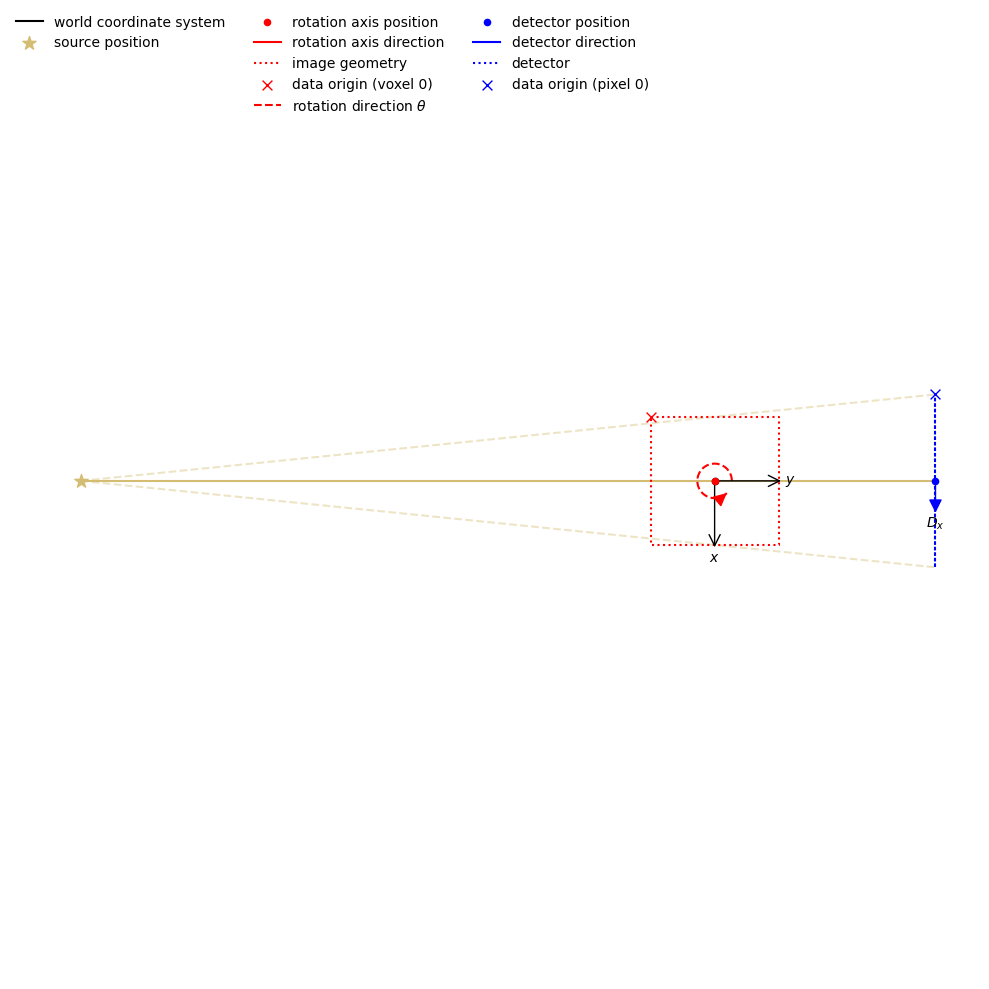

In [266]:
show_geometry(ag)

In [267]:
# Setup image geometry
n = num_pixels
ig = ag.get_ImageGeometry()
ig.voxel_num_x = n
ig.voxel_num_y = n
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x560,y560
voxel_size : x0.14832231733304438,y0.14832231733304438
center : x0,y0



In [268]:
# Setup data
stempoData = AcquisitionData(sinogram, deep_copy=False, geometry=ag)

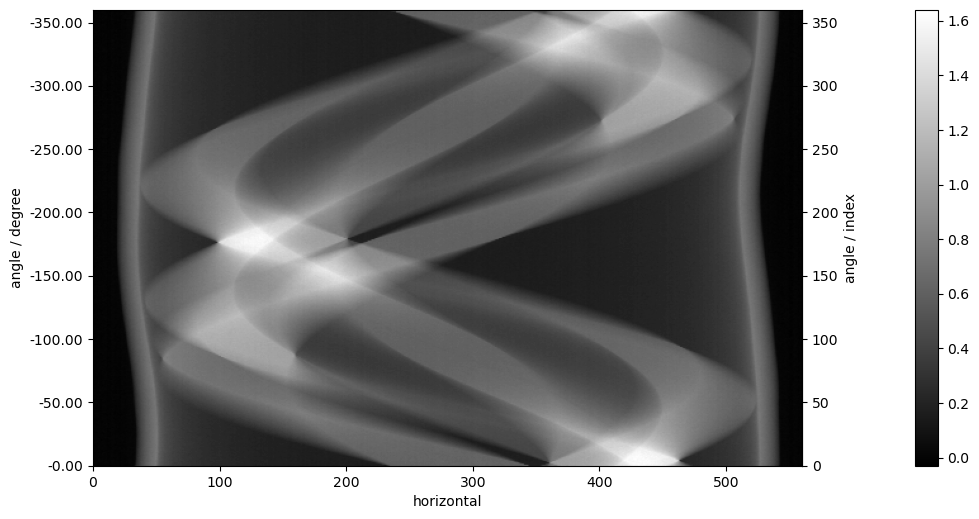

In [269]:
show2D(stempoData,size=(10,10))

## 2. FBP of the static data

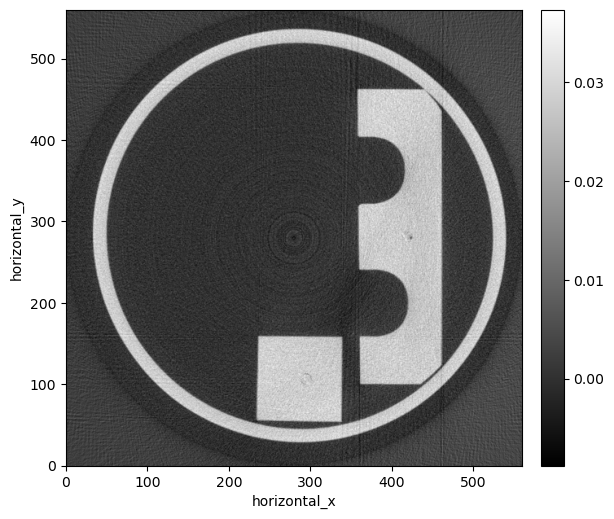

In [270]:
fbp = FBP(ig, ag, 'gpu')
# run on the AcquisitionData
recon_fbp = fbp(stempoData)
show2D(recon_fbp,size=(10,10))

## 3. Repeat the previous steps with dynamic data

**Note**: variable names are reused

In [271]:
# Load data
filename = "stempo_seq8x45_2d_b4.mat"
data = mat73.loadmat(filename)
CtData = data["CtData"]
sinogram = np.float32(CtData["sinogram"])
# Load parameters
param = CtData["parameters"]
angles = np.float32(param["angles"])

binningFactor = param["binningPost"]
SOD = param["distanceSourceOrigin"]
print(f'SOD: {SOD:.3f} mm')
SDD = param["distanceSourceDetector"]
print(f'SDD: {SDD:.3f} mm')
ODD = SDD - SOD # Origin-detector-distance
print(f'ODD: {ODD:.3f} mm')
pixelSize = param["pixelSizePost"]
print(f'Detector pixel size: {pixelSize:.3f} mm')

# Acquisition geometry
ag = AcquisitionGeometry.create_Cone2D([0,-SOD], [0,ODD], units='mm',detector_direction_x=[1, 0])
num_angles, num_pixels = sinogram.shape
ag.set_panel(num_pixels, pixel_size=pixelSize, origin='bottom-left')
ag.set_angles(-angles)
ag.set_labels(('angle','horizontal'))

print(ag)

# Setup image geometry
n = 540
ig = ag.get_ImageGeometry()
ig.voxel_num_x = n
ig.voxel_num_y = n
print(ig)

SOD: 410.660 mm
SDD: 553.740 mm
ODD: 143.080 mm
Detector pixel size: 0.200 mm
2D Cone-beam tomography
System configuration:
	Source position: [   0.  , -410.66]
	Rotation axis position: [0., 0.]
	Detector position: [  0.  , 143.08]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [560   1]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 360
	Angles 0-20 in degrees:
[  -0.,   -8.,  -16.,  -24.,  -32.,  -40.,  -48.,  -56.,  -64.,  -72.,
  -80.,  -88.,  -96., -104., -112., -120., -128., -136., -144., -152.]
Distances in units: mm
Number of channels: 1
channel_spacing: 1.0
voxel_num : x540,y540
voxel_size : x0.14832231733304438,y0.14832231733304438
center : x0,y0



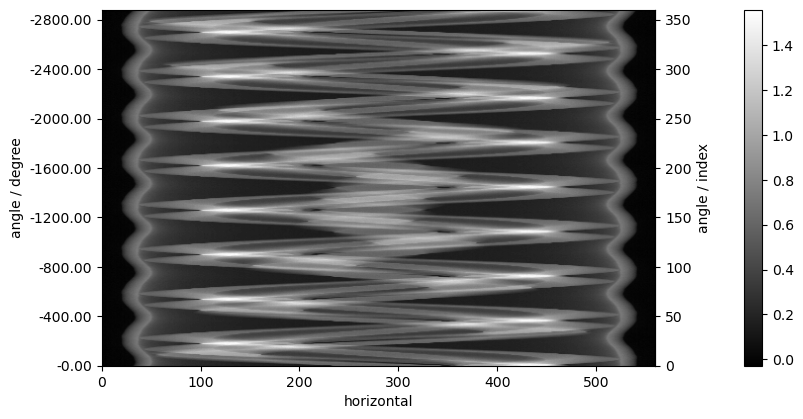

In [272]:
# Setup data
stempoData = AcquisitionData(sinogram, deep_copy=False, geometry=ag)
show2D(stempoData, size=(8,8))

We can get a better look by just using Matplotlib because I can not seem to get any other aspect ratio working with `show2D`.

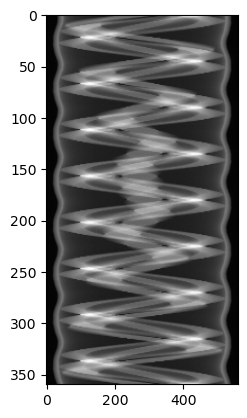

In [273]:
plt.imshow(sinogram, cmap='gray', aspect=3)

The sinogram looks rather busy since it contains (sparse set of) projections from 8 full rotations around the object.

### 3.1 Witness the movement artefacts

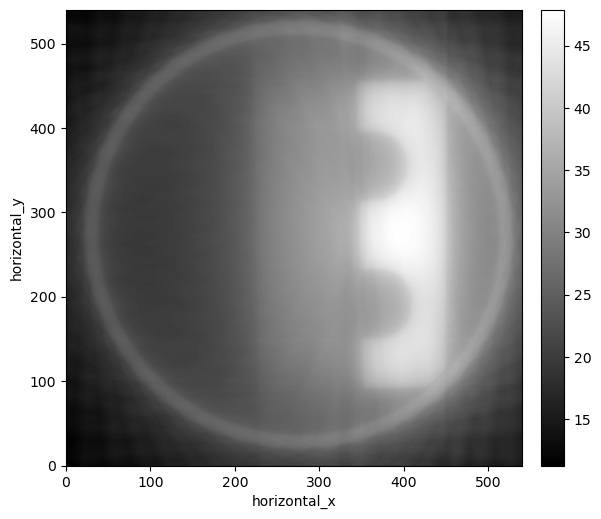

In [274]:
# Create projection operator using Astra-Toolbox.
A = ProjectionOperator(ig, ag, 'gpu')

bp = A.adjoint(stempoData) # Backgprojection
show2D(bp, size=(10,10))

### 3.2 FBP reconstruction of a dynamic data

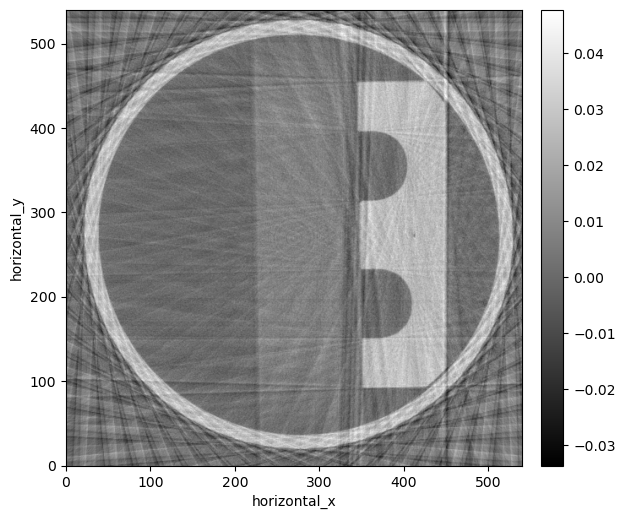

In [275]:
fbp = FBP(ig, ag, 'gpu')
# run on the AcquisitionData
recon_fbp = fbp(stempoData)
show2D(recon_fbp,size=(10,10))

That looks terrible. Let's remove negative pixel values.

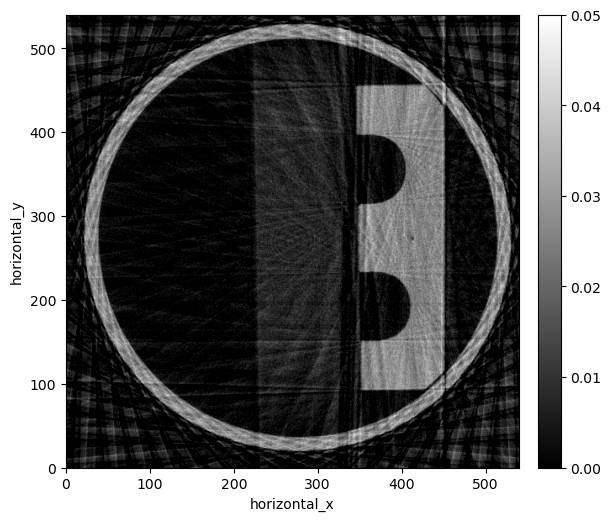

In [276]:
show2D(recon_fbp, size=(10,10), fix_range=(0,0.05))

Now it only looks bad. We can see notable motion artefacts in the middle and a lot of sparse angle artefacts since we only have 45 unique projection directions.

### 3.3 Iterative methods have the same artefacts

In [277]:
# initial estimate - zero array in this case 
initial = ig.allocate(0)

# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=stempoData,
            max_iteration = 100,
            update_objective_interval = 10 )

In [278]:
cgls.run(50,verbose=True)
# get and visualise the results
recon_cgls = cgls.solution

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          6.73190e+04
       10        100         0.199          3.45551e+03
       20        100         0.194          3.43863e+03
       30        100         0.188          3.43665e+03
       40        100         0.186          3.43600e+03
       50        100         0.173          3.43566e+03
-------------------------------------------------------
       50        100         0.173          3.43566e+03
Stop criterion has been reached.



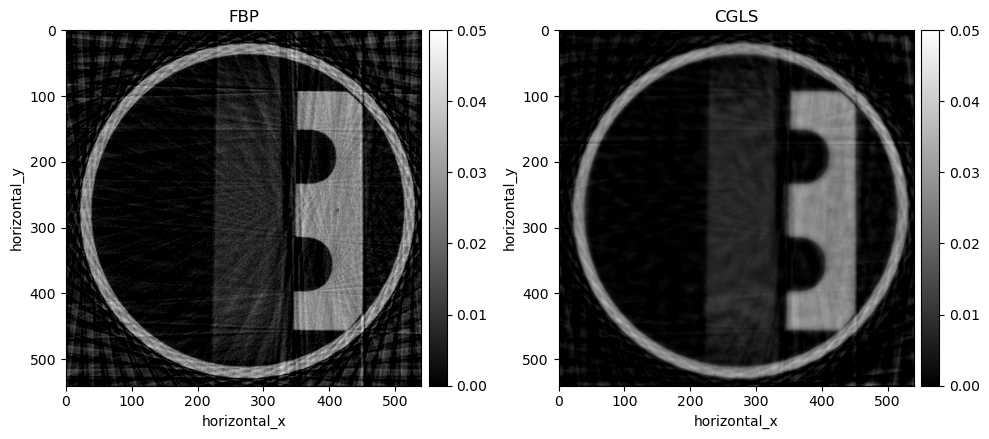

In [279]:
show2D([recon_fbp, recon_cgls], ['FBP', 'CGLS'], \
       num_cols=2, size=(10,10), origin='upper-left', fix_range=(0,0.05))

### 3.4 Consider only one time step (out of 8)

Sinogram size is now (45, 560)


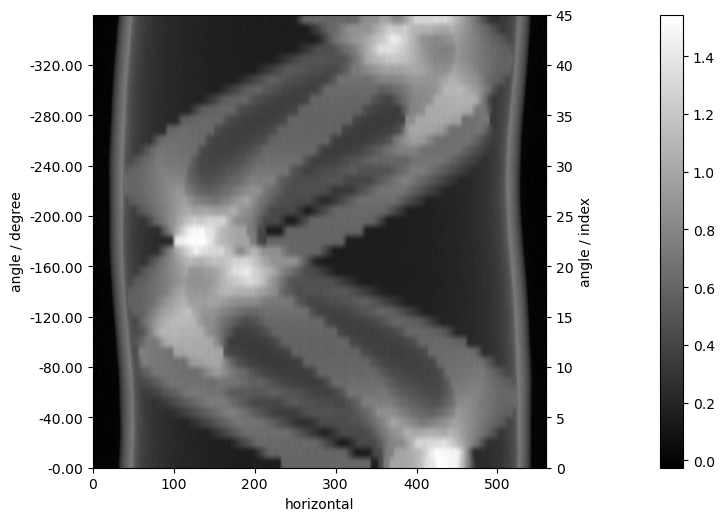

In [280]:
# Limited angles
# We cut a small section out of the sinogram and angles
numAngles = 45
anglesSparse = angles[0:numAngles]
sinoSparse = sinogram[0:numAngles,:]
print(f'Sinogram size is now {sinoSparse.shape}')

agSparse = ag.copy()
agSparse.set_angles(-anglesSparse)
stempoSparse = AcquisitionData(sinoSparse, deep_copy=False, geometry=agSparse)
show2D(stempoSparse, size=(10,10))

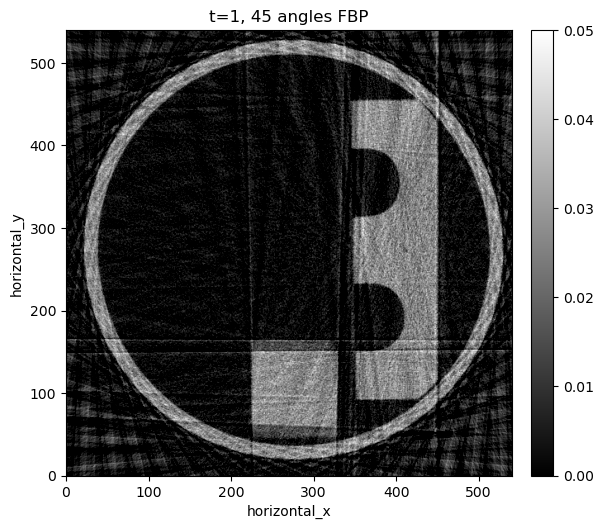

In [281]:
fbp = FBP(ig, agSparse, 'gpu')
# run on the AcquisitionData
sparse_fbp = fbp(stempoSparse)
show2D(sparse_fbp, size=(10,10), fix_range=(0,0.05), title='t=1, 45 angles FBP')

Some movement artefacts are still visible but the situations has improved. Let's try iterative algorithm (cgls).

In [282]:
A = ProjectionOperator(ig, agSparse, 'gpu')
# initial estimate - zero array in this case 
initial = ig.allocate(0)

# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=stempoSparse,
            max_iteration = 100,
            update_objective_interval = 10 )

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          8.42717e+03
       10        100         0.049          1.65551e+01
       20        100         0.045          1.36376e+01
       30        100         0.044          1.30771e+01
       40        100         0.042          1.28557e+01
       50        100         0.041          1.27849e+01
-------------------------------------------------------
       50        100         0.041          1.27849e+01
Stop criterion has been reached.



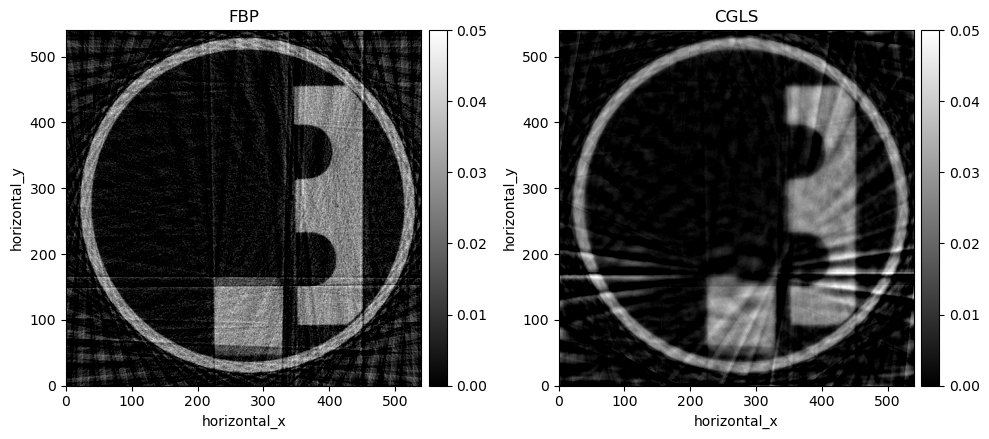

In [283]:
cgls.run(50,verbose=True)
# get and visualise the results
sparse_cgls = cgls.solution

show2D([sparse_fbp, sparse_cgls], ['FBP', 'CGLS'], \
       num_cols=2, size=(10,10), fix_range=(0,0.05))

In [284]:
# Tikhonov regularization with one time step
L = IdentityOperator(ig)
alpha = 0.1

operator_block = BlockOperator(A, alpha*L)
zero_data = L.range.allocate(0)

data_block = BlockDataContainer(stempoSparse, zero_data)

In [285]:
#setup CGLS with the Block Operator and Block DataContainer
initial = ig.allocate(0)      
cgls_tikh = CGLS(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_tikh.max_iteration = 1000


In [286]:
#run the algorithm
cgls_tikh.run(100)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.42717e+03
       10       1000         0.046          1.69950e+01
       20       1000         0.048          1.40907e+01
       30       1000         0.047          1.35413e+01
       40       1000         0.046          1.33292e+01
       50       1000         0.045          1.32618e+01
       60       1000         0.045          1.33236e+01
       70       1000         0.045          1.35533e+01
       80       1000         0.044          1.40137e+01
       90       1000         0.044          1.48241e+01
      100       1000         0.044          1.61588e+01
-------------------------------------------------------
      100       1000         0.044          1.61588e+01
Stop criterion has been reached.



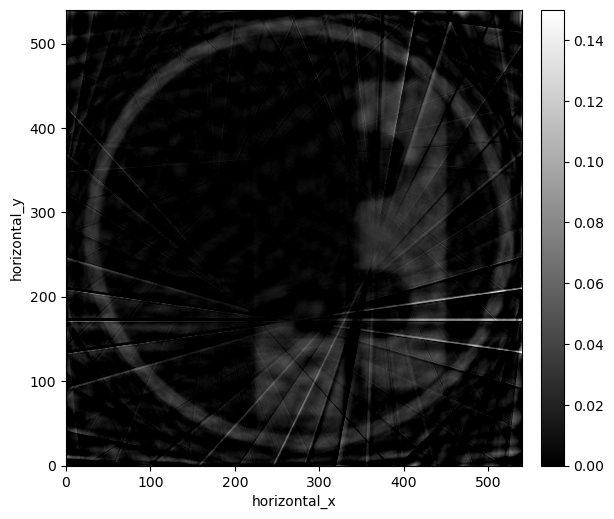

In [287]:
show2D(cgls_tikh.solution, size=(10,10), fix_range=(0,0.15))

### 3.5 Just in case, test FISTA with one time step

In [288]:
A = ProjectionOperator(ig, agSparse, 'gpu')
LS = LeastSquares(A=A, b=stempoSparse)
fista_LS = FISTA(initial=ig.allocate(0), f=LS, g=ZeroFunction(), max_iteration=1000, update_objective_interval=10)

In [289]:
fista_LS.run(100)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.42717e+03
       10       1000         0.040          7.14035e+01
       20       1000         0.040          1.77895e+01
       30       1000         0.040          1.48522e+01
       40       1000         0.039          1.39117e+01
       50       1000         0.039          1.34575e+01
       60       1000         0.038          1.32090e+01
       70       1000         0.038          1.30346e+01
       80       1000         0.038          1.29069e+01
       90       1000         0.038          1.28115e+01
      100       1000         0.038          1.27332e+01
-------------------------------------------------------
      100       1000         0.038          1.27332e+01
Stop criterion has been reached.



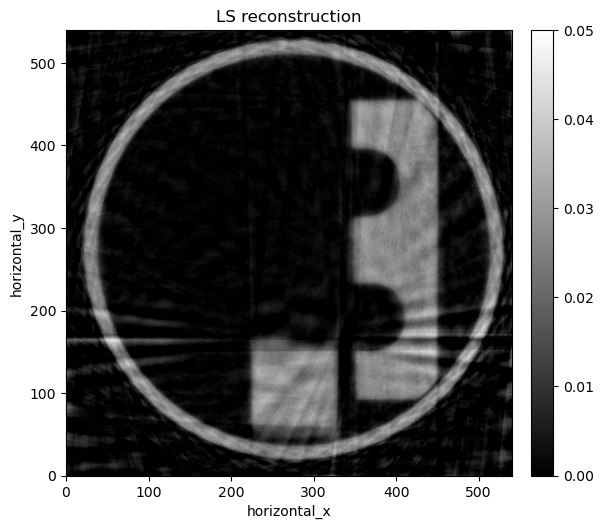

In [290]:
LS_reco = fista_LS.solution
show2D(LS_reco, title="LS reconstruction", fix_range=(0,0.05), size=(10,10))

## 4. Split into separate time steps
We want to treat data mismatch of each time step separately but consider only one 2d + time object $f$, i.e. something like
$$
\Big\| \sum_{t=0}^{T-1} A f_t - m_t \Big\|^2 + \alpha R(f)
$$

In [291]:
## Split time steps
T = 8
from cil.framework.framework import Partitioner, DataContainer
from cil.optimisation.functions import L2NormSquared, L1Norm
from cil.optimisation.functions import MixedL21Norm
from cil.optimisation.functions import BlockFunction
from cil.optimisation.operators import ZeroOperator
stempoSplit = stempoData.partition(T, Partitioner.SEQUENTIAL)

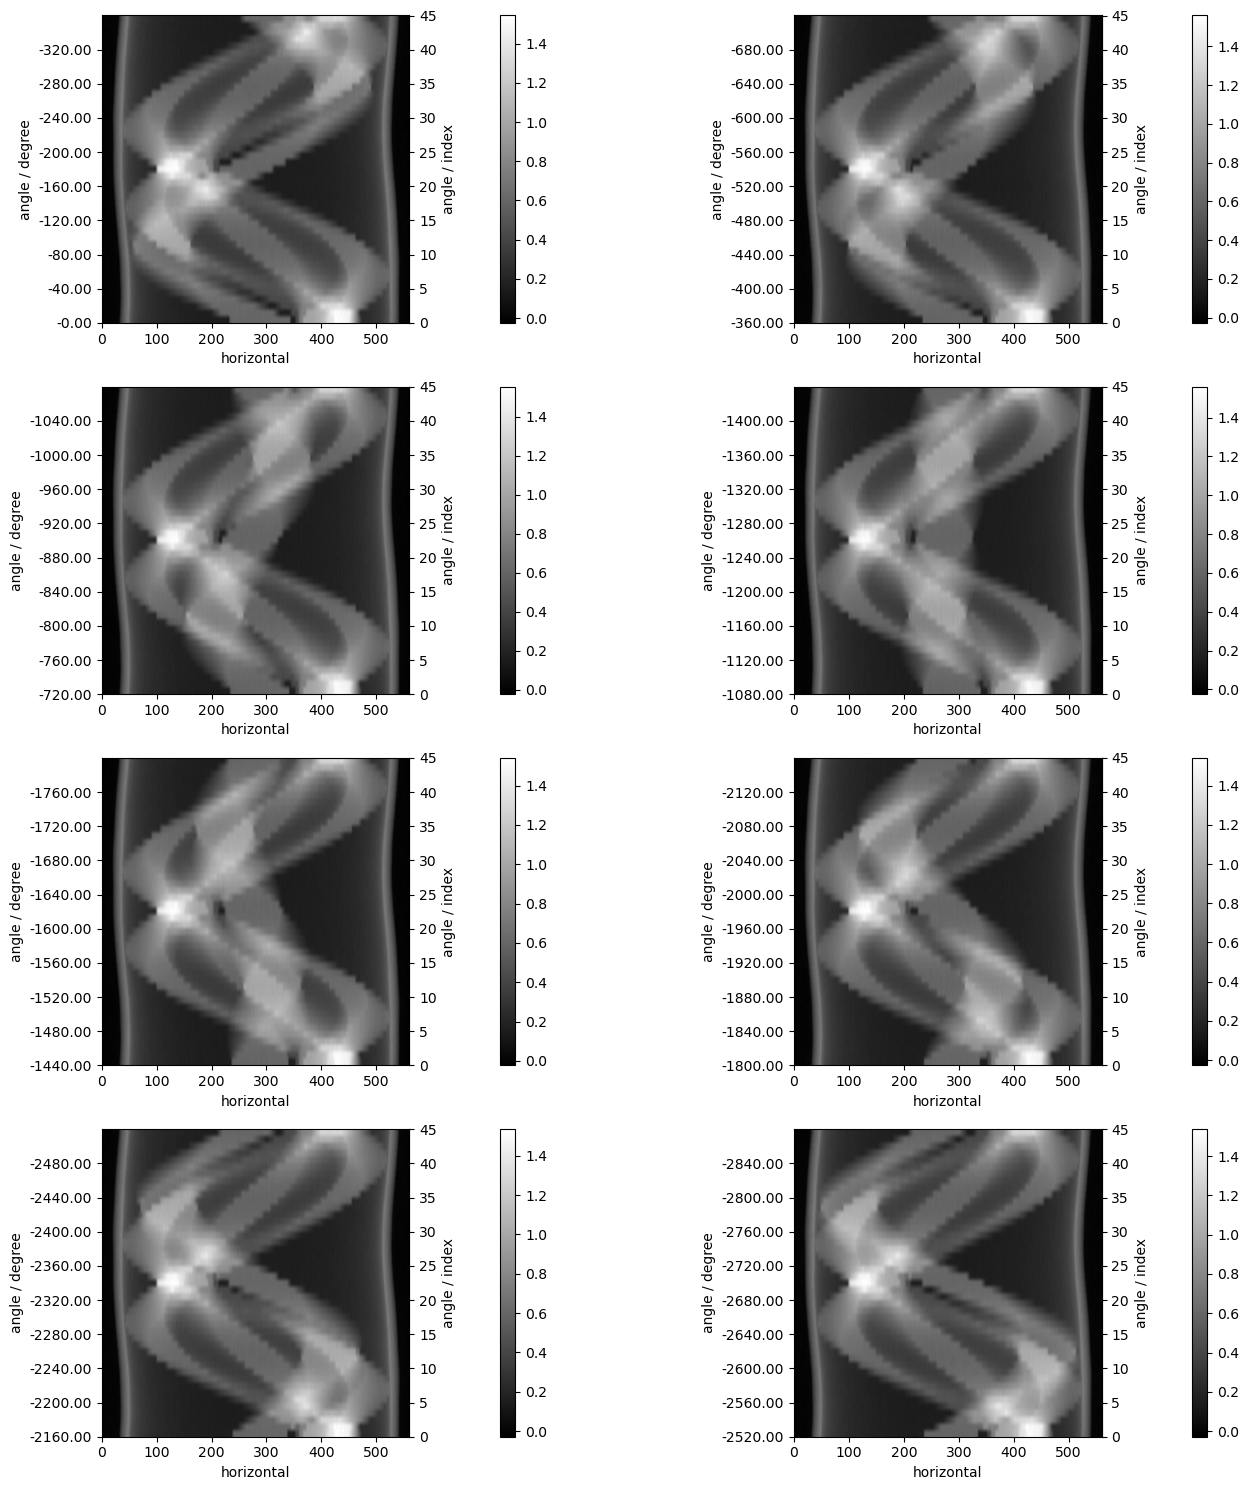

In [292]:
show2D(stempoSplit)

### 4.1 Build block (diagonal) operators
Regular block operators and functions are block-like either in row or column direction, what we want is something like
$$
A_{big} =
\left(\begin{array}{cccc} 
A_0 & 0 & \dots & 0 \\
0 & A_1 & \dots & 0 \\
\vdots & & \ddots & \vdots \\
0 & 0 & \dots & A_{T-1}
\end{array}\right).
$$ 
Unfortunately at the moment CIL can not create such operators in efficient (sparse) way. So we have to do it inefficiently.

In [293]:
projOp = ProjectionOperator(ig, stempoSplit.geometry)
projOpList = projOp.get_as_list() # List of the operators we want

# We need a zero-operator for padding (If the sizes changed for different time steps this would be pain)
# (Luckily they don't)
ZOp = ZeroOperator(projOpList[0].domain_geometry(), projOpList[0].range_geometry())

Alist = [ZOp for i in range(T*T)] # Long list of zero-operators
# Fill diagonal with proper operators
for t in range(T):
    Alist[t*T+t] = projOpList[t]

# Obtain block-diagonal square operator
A = BlockOperator(*Alist, shape=(T,T))

bList = [stempoSplit.get_item(i) for i in range(T)]
b = BlockDataContainer(*bList)

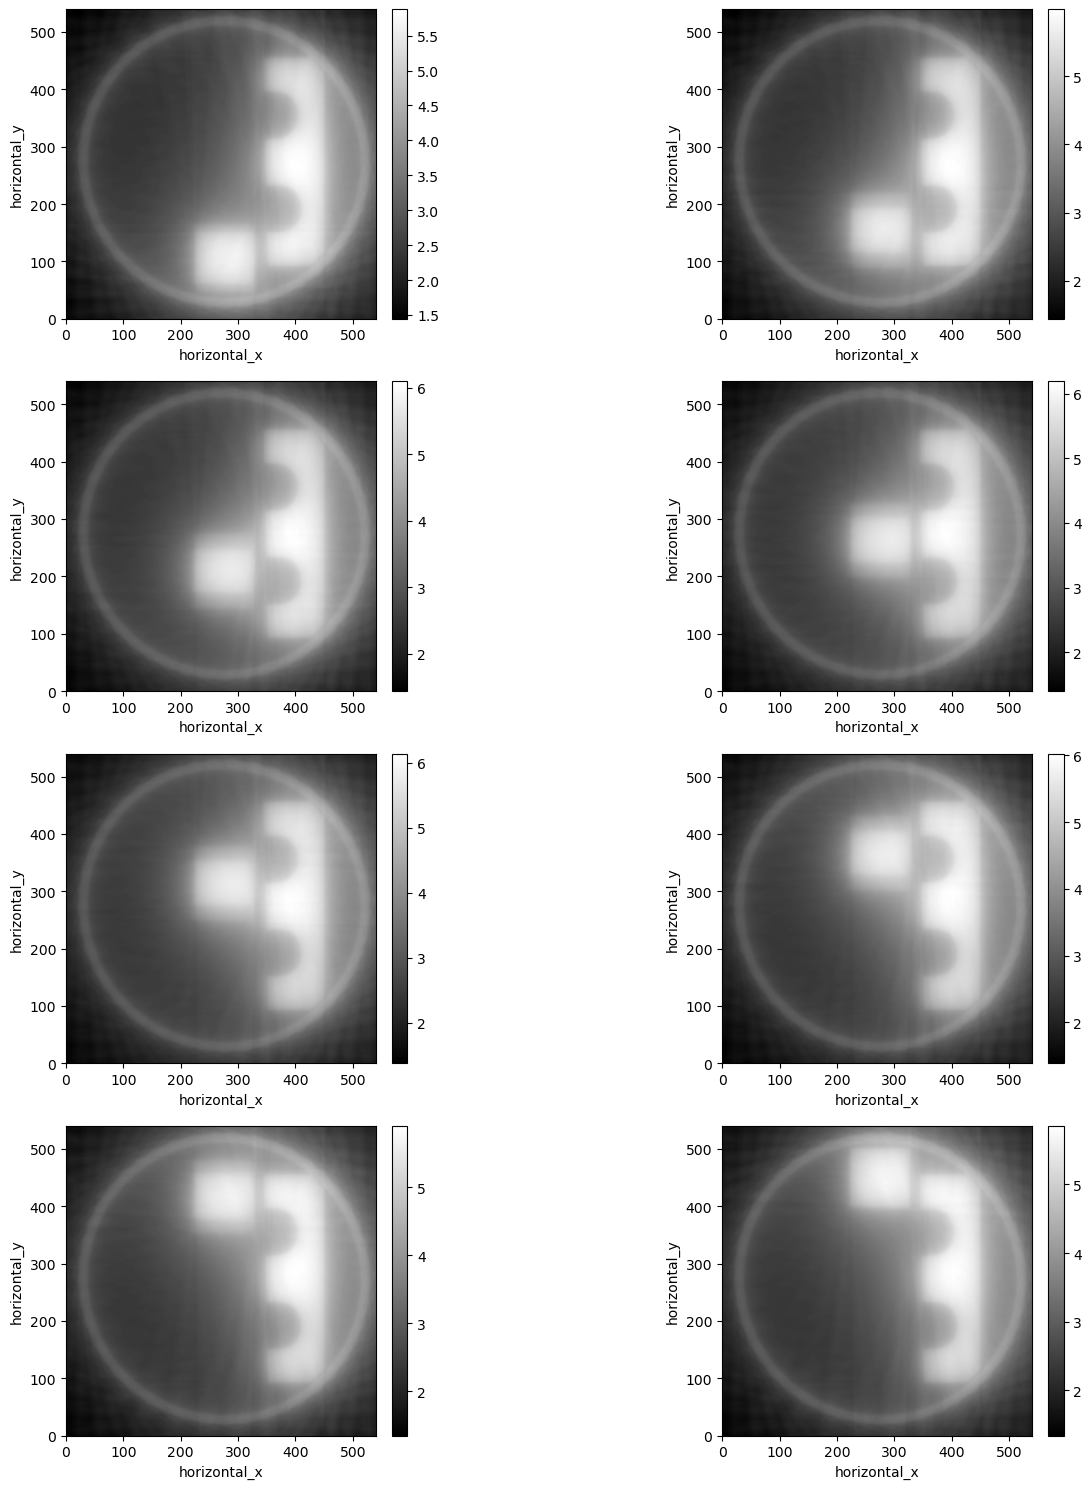

In [294]:
# Initial value using A
x0 = A.adjoint(b)
# Sanity check: we should see 8 different images
show2D(x0)


In [295]:
# We initialize with zeros, which we have to do by iterating each image
for t in range(T):
    x0[t].fill(0.0)

## 5. Iterative algorithms with multiple time steps

### 5.1 FISTA with non-negativity constraint for each time step

In [296]:
# Nonnegativity constraint block function to act on each image separately
IBList = [IndicatorBox(lower=0.0) for i in range(T)]
IB = BlockFunction(*IBList)

# One large least squares term
F_LS = LeastSquares(A=A, b=stempoSplit)

# Set up FISTA algorithm
fista = FISTA(initial=x0, f=F_LS, g=IB, max_iteration=200, update_objective_interval=10)

In [297]:
fista.run(100)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          6.73190e+04
       10        200         0.376          5.86625e+03
       20        200         0.375          2.03110e+03
       30        200         0.375          8.11439e+02
       40        200         0.371          4.63374e+02
       50        200         0.369          3.24651e+02
       60        200         0.367          2.71682e+02
       70        200         0.368          2.53289e+02
       80        200         0.368          2.43930e+02
       90        200         0.367          2.38423e+02
      100        200         0.367          2.35406e+02
-------------------------------------------------------
      100        200         0.367          2.35406e+02
Stop criterion has been reached.



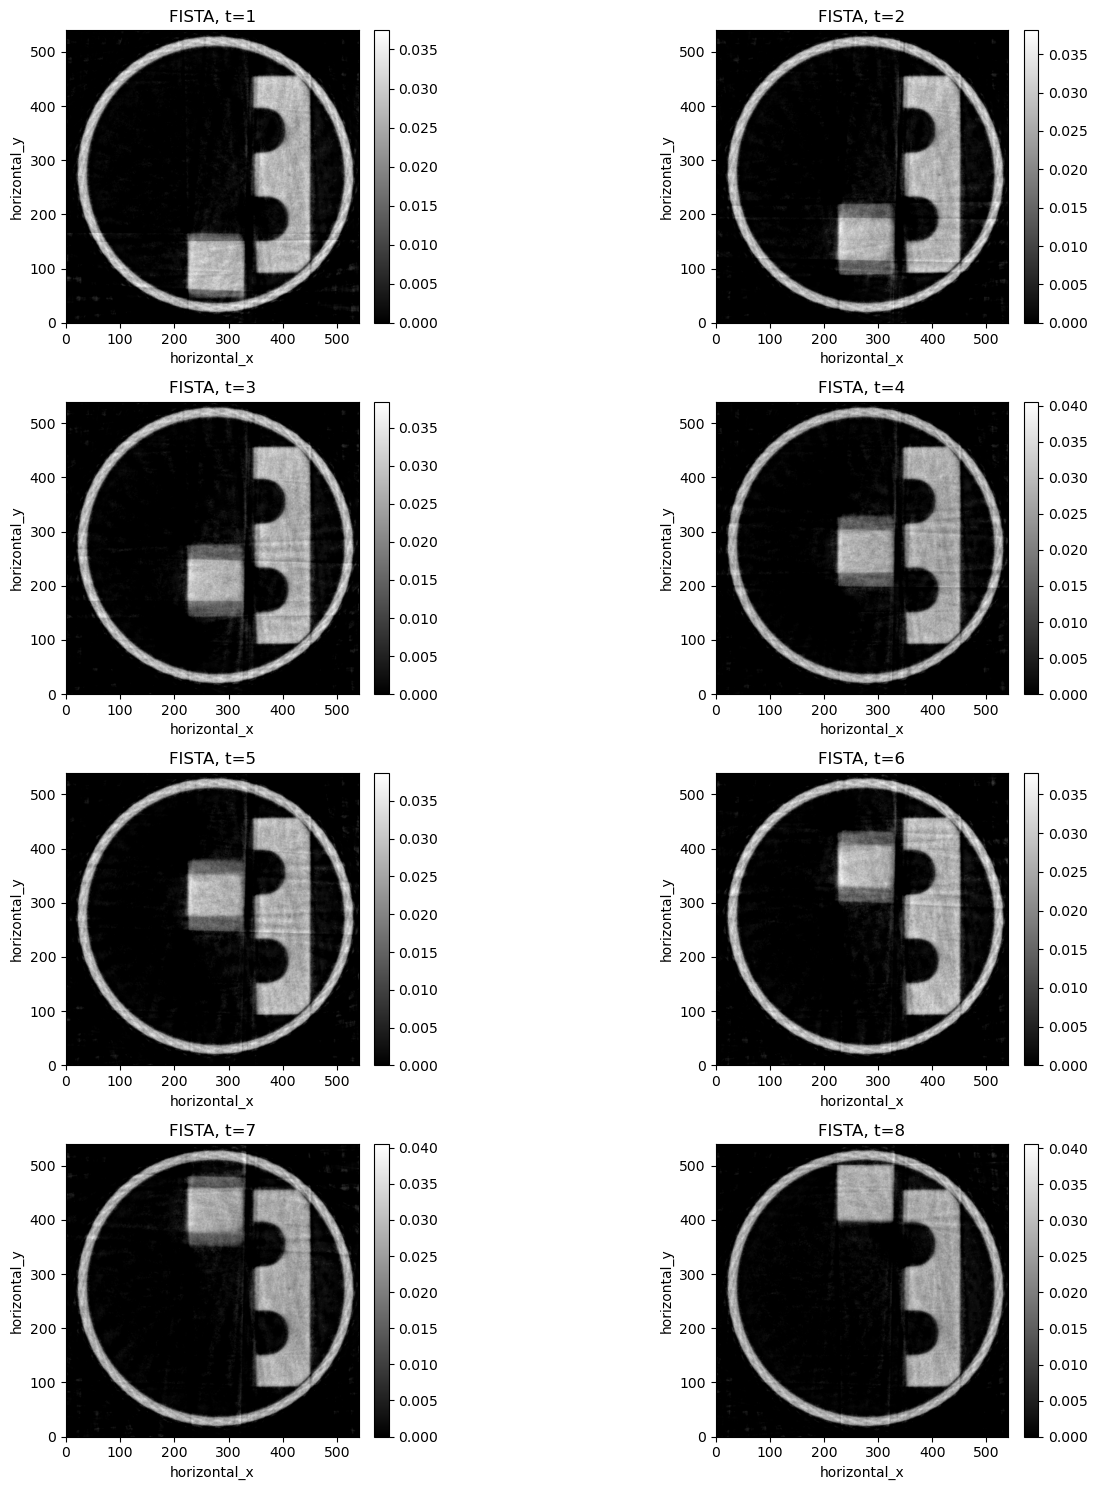

In [298]:
FISTArecn = fista.solution
show2D(FISTArecn, title=[f'FISTA, t={t+1}' for t in range(T)])

### 5.2 Let's do some (spatial) TV regularization

In [299]:
from cil.plugins.ccpi_regularisation.functions import FGP_TV

In [300]:
alpha = 0.05
TVlist = [FGP_TV(alpha=alpha, nonnegativity=True, device='gpu', isotropic=False) for t in range(T)]
TV = BlockFunction(*TVlist) # Unroll the list as before

fista_TV = FISTA(initial=x0, f=F_LS, g=TV, max_iteration=500, update_objective_interval=10)

In [301]:
fista_TV.run(100)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.73190e+04
       10        500         2.273          5.88299e+03
       20        500         2.229          2.07038e+03
       30        500         2.199          8.61867e+02
       40        500         2.185          5.19534e+02
       50        500         2.192          3.84050e+02
       60        500         2.221          3.32823e+02
       70        500         2.245          3.15552e+02
       80        500         2.252          3.06732e+02
       90        500         2.244          3.01659e+02
      100        500         2.230          2.98781e+02
-------------------------------------------------------
      100        500         2.230          2.98781e+02
Stop criterion has been reached.



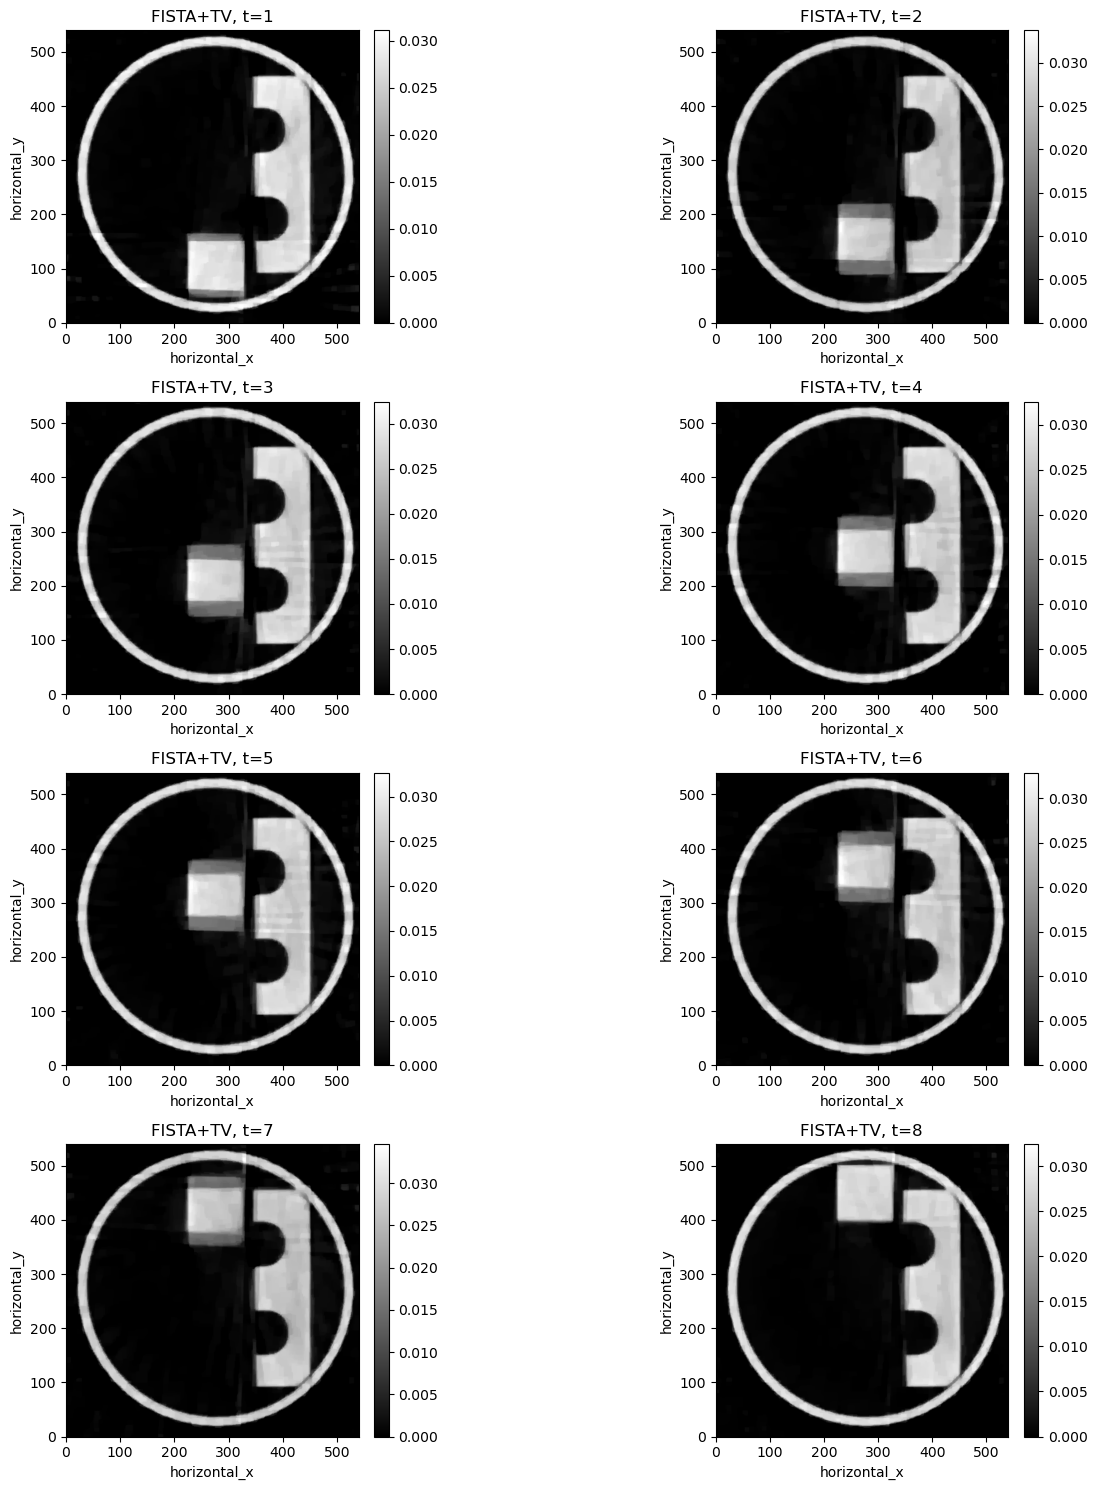

In [302]:
FISTATVrecn = fista_TV.solution
show2D(FISTATVrecn, title=[f'FISTA+TV, t={t+1}' for t in range(T)])

This doesn't seem too bad. However our block-diagonal approach does have its limits. Let's push them!

## 6. Hacky temporal TV
 i.e. so many block diagonal operators...

 For temporal TV we want to subtract subsequent time steps: $f_t - f_{t+1}$. We can do this with a linear operator:

$$
D_{t} =
\left(\begin{array}{ccccc} 
I & -I & 0 & \dots & 0 \\
0 & I & -I & \dots & 0 \\
\vdots & & & \ddots & \vdots \\
0 & & \dots & I & -I \\
0 & & \dots & & 0
\end{array}\right)
$$ 
and then do $R(f) = \alpha \| D_t f \|_2^2 $.

Problem is, we have very limited options for creating the operator such that the optimization methods still work. Luckily there is a way...

### 6.1 Let's use MASSIVE block operators
(This will be slow)

$$
M =
\left(\begin{array}{cc} 
A_{big} \\
\alpha D_t
\end{array}\right) = 
\left(\begin{array}{ccc} 
A_0 & \dots & 0 \\
& \ddots &  \\
0 & \dots & A_{T-1} \\
\alpha I & -\alpha I & \\
& \ddots & \\
0 & \dots & 0
\end{array}\right)
, \quad B = \left(\begin{array}{cc} 
b_0 \\
\vdots \\
b_{T-1} \\
0 \\
\vdots \\
0
\end{array}\right)
$$ 
and do least squares term with that

$$ \| M f - B \|_2^2 = \| A_{big} f - b \|_2^2 + \alpha^2 \| D_t f \|_2^2.$$

This way our functional will be

$$
\mathcal{F}(f) = \sum_{t=0}^{T-1} \left( \| A f_t - b_t \|_2^2 + \beta \, TV(f_t) \right) + \alpha^2 \| D_t f \|_2^2 .
$$

In [303]:
from cil.optimisation.operators import IdentityOperator

projOp = ProjectionOperator(ig, stempoSplit.geometry)
projOpList = projOp.get_as_list() # List of the operators we want

# We want the zero operator to have same domain and range as the forward operator projOp
ZOp1 = ZeroOperator(projOpList[0].domain_geometry(), projOpList[0].range_geometry())
Alist = [ZOp1 for i in range(T*T)] # Long list of zero-operators
# Fill diagonal with proper operators
for t in range(T):
    Alist[t*T+t] = projOpList[t]

# Now we want to make each block operate from image domain to image domain!
ZOp2 = ZeroOperator(projOpList[0].domain_geometry(), projOpList[0].domain_geometry())
IOp = IdentityOperator(projOpList[0].domain_geometry(), projOpList[0].domain_geometry())

alpha = 5 # Regularization parameter for temporal TV

DtList = [ZOp2 for i in range(T*T)] # Long list of zero-operators
# Fill diagonal and off-diagonal with proper operators (last row is zeroes for simplicity)
for t in range(T-1):
    DtList[t*T+t] = alpha*IOp
    DtList[np.min((t,T-2))*T+t+1] = -alpha*IOp

# Use existing lists of operators and concanate
Mlist = [*Alist, *DtList]
# Obtain block-diagonal rectangular operator
M = BlockOperator(*Mlist, shape=(2*T,T))

bList = [stempoSplit.get_item(i) for i in range(T)]
x0List = [x0[i] for i in range(T)]
B = BlockDataContainer(*[*bList, *x0List]) # Concanate lists

MASSIVE_LS = LeastSquares(A=M, b=B)

In [304]:
# Let's add spatial TV to the mix (luckily it can also include non-negativity)
beta = 0.05 # Regularization parameter for spatial TV

TV = BlockFunction(*[FGP_TV(alpha=beta, nonnegativity=True, device='gpu', isotropic=False) for t in range(T)])

In [305]:
# We can set function g to be just non-negativity constraint (g=IB) or non-negativity + spatial TV (g=TV)
# Note that including spatial TV will make the algorithm even slower!
fista_MASSIVE = FISTA(initial=x0, f=MASSIVE_LS, g=TV, max_iteration=100, update_objective_interval=10)

So far so good. Fingers crossed it runs...

In [306]:
fista_MASSIVE.run(50)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          6.73190e+04
       10        100         2.254          6.32259e+03
       20        100         2.338          2.61179e+03
       30        100         2.373          1.43551e+03
       40        100         2.356          1.06185e+03
       50        100         2.337          9.13366e+02
-------------------------------------------------------
       50        100         2.337          9.13366e+02
Stop criterion has been reached.



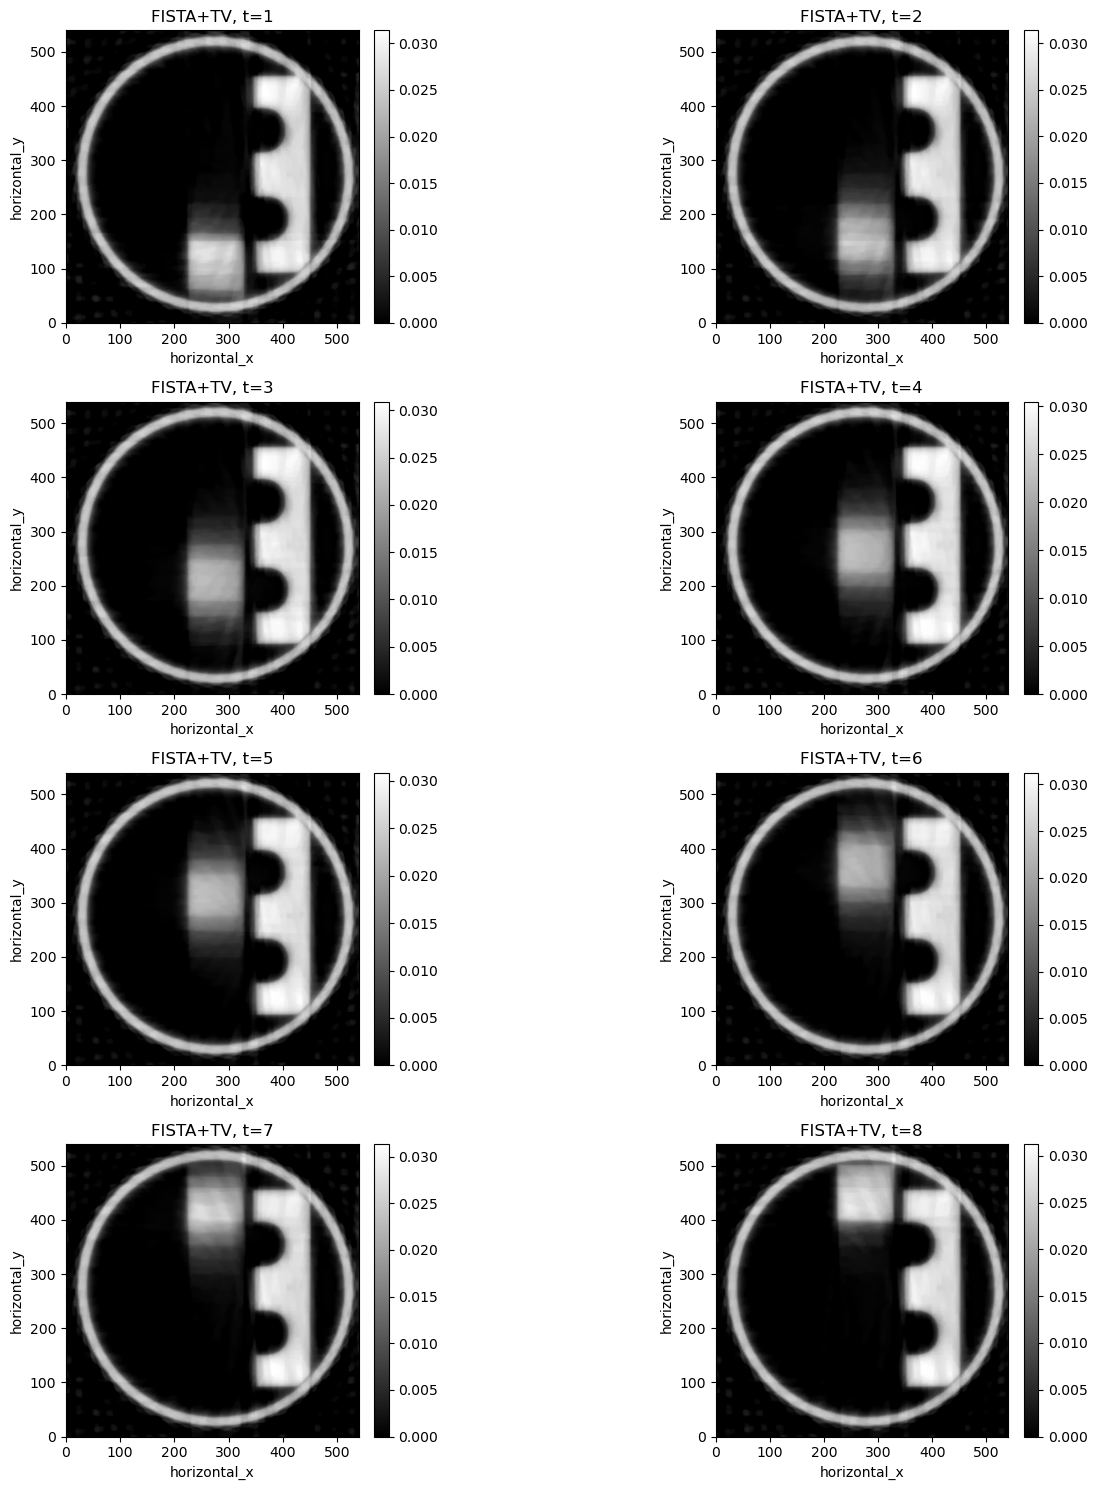

In [307]:
MASSIVErecn = fista_MASSIVE.solution
show2D(MASSIVErecn, title=[f'FISTA+TV, t={t+1}' for t in range(T)])

### Comments

It is possible to obtain (isotropic) temporal TV this way. Whether you actually *should* do it is another question. It's definitely not efficient. Also the isotropic TV may not be the best choice because it seems to cause motion artefacts as it smooths the temporal evolution.

Nevertheless it is a fun experiment and illustrates the capabilities of CIL. Although I am not sure these are all *desired* capabilities...